<a href="https://colab.research.google.com/github/GAURAV-AgarwL/Surface-Crack-Detection/blob/main/Exploratory_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from IPython import get_ipython
from IPython.display import display

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import kagglehub

path = kagglehub.dataset_download("arunrk7/surface-crack-detection")

positive_dir = Path(path) / 'Positive'
negative_dir = Path(path) / 'Negative'


In [ ]:
def generate_df(image_dir,label):
  filepath = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
  label = pd.Series(label, name='Label', index=filepath.index)
  df = pd.concat([filepath, label], axis=1)
  return df

positive_df = generate_df(positive_dir,'Positive')
negative_df = generate_df(negative_dir,'Negative')

whole_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

whole_df.head()

,Filepath,Label
0,/kaggle/input/surface-crack-detection/Positive...,Positive
1,/kaggle/input/surface-crack-detection/Positive...,Positive
2,/kaggle/input/surface-crack-detection/Positive...,Positive
3,/kaggle/input/surface-crack-detection/Negative...,Negative
4,/kaggle/input/surface-crack-detection/Positive...,Positive


In [ ]:
number_of_samples = len(whole_df)

sample_size = 6000
train_df,test_df = train_test_split(whole_df.sample(sample_size, random_state=1), train_size=0.7, shuffle=True, random_state=1)

number_of_samples

40000

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_data= train_generator.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size = 32,
    shuffle = True,
    seed  = 42,
    subset = 'training'
)

validate_data = train_generator.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = test_generator.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [ ]:
inputs = tf.keras.Input(shape = (120,120,3))
x=tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x= tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x= tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x= tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x= tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(
    train_data,
    validation_data=validate_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 33s 287ms/step - accuracy: 0.5183 - loss: 0.6920 - val_accuracy: 0.4929 - val_loss: 0.6902
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5587 - loss: 0.6845 - val_accuracy: 0.7214 - val_loss: 0.6599
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.7198 - loss: 0.6396 - val_accuracy: 0.7262 - val_loss: 0.6119
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.7219 - loss: 0.5993 - val_accuracy: 0.7381 - val_loss: 0.5799
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.7287 - loss: 0.5760 - val_accuracy: 0.7964 - val_loss: 0.5541
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7960 - loss: 0.5385 - val_accuracy: 0.8286 - val_loss: 0.5282
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8497 - loss: 0.5018 - val_accuracy: 0.8512 - val_loss: 0.4896
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8625 - loss: 0.474

In [ ]:
def evaluate_model(model, test_data):
    model.evaluate(test_data)
    y_preds = model.predict(test_data)
    y_true = test_data.classes
    accuracy = accuracy_score(y_true, y_preds.round())
    print(f"Model accuracy: {accuracy:.2f}")
    precision = precision_score(y_true, y_preds.round())
    print(f"Model precision: {precision:.2f}")
    recall = recall_score(y_true, y_preds.round())
    print(f"Model recall: {recall:.2f}")
    f1 = f1_score(y_true, y_preds.round())
    print(f"Model f1: {f1:.2f}")
    cm = confusion_matrix(y_true, y_preds.round())
    print(f"Model confusion matrix:\n{cm}")
    return y_preds

In [ ]:
evaluate_model(model, test_data)

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.9414 - loss: 0.2258
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
Model accuracy: 0.94
Model precision: 0.98
Model recall: 0.89
Model f1: 0.94
Model confusion matrix:
[[904  13]
 [ 95 788]]


array([[0.11046897],
       [0.10591868],
       [0.99999607],
       ...,
       [0.1013355 ],
       [0.99999774],
       [0.93279326]], dtype=float32)

Saving WhatsApp Image 2025-05-05 at 4.23.13 PM.jpeg to WhatsApp Image 2025-05-05 at 4.23.13 PM.jpeg
Saving WhatsApp Image 2025-05-05 at 4.23.12 PM (2).jpeg to WhatsApp Image 2025-05-05 at 4.23.12 PM (2).jpeg
Saving WhatsApp Image 2025-05-05 at 4.23.12 PM (1).jpeg to WhatsApp Image 2025-05-05 at 4.23.12 PM (1).jpeg
Saving WhatsApp Image 2025-05-05 at 4.23.12 PM.jpeg to WhatsApp Image 2025-05-05 at 4.23.12 PM.jpeg
Saving WhatsApp Image 2025-05-06 at 1.08.20 AM.jpeg to WhatsApp Image 2025-05-06 at 1.08.20 AM.jpeg
Saving WhatsApp Image 2025-05-06 at 1.08.19 AM.jpeg to WhatsApp Image 2025-05-06 at 1.08.19 AM.jpeg
User uploaded file "WhatsApp Image 2025-05-05 at 4.23.13 PM.jpeg" with length 1034037 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
No crack detected.


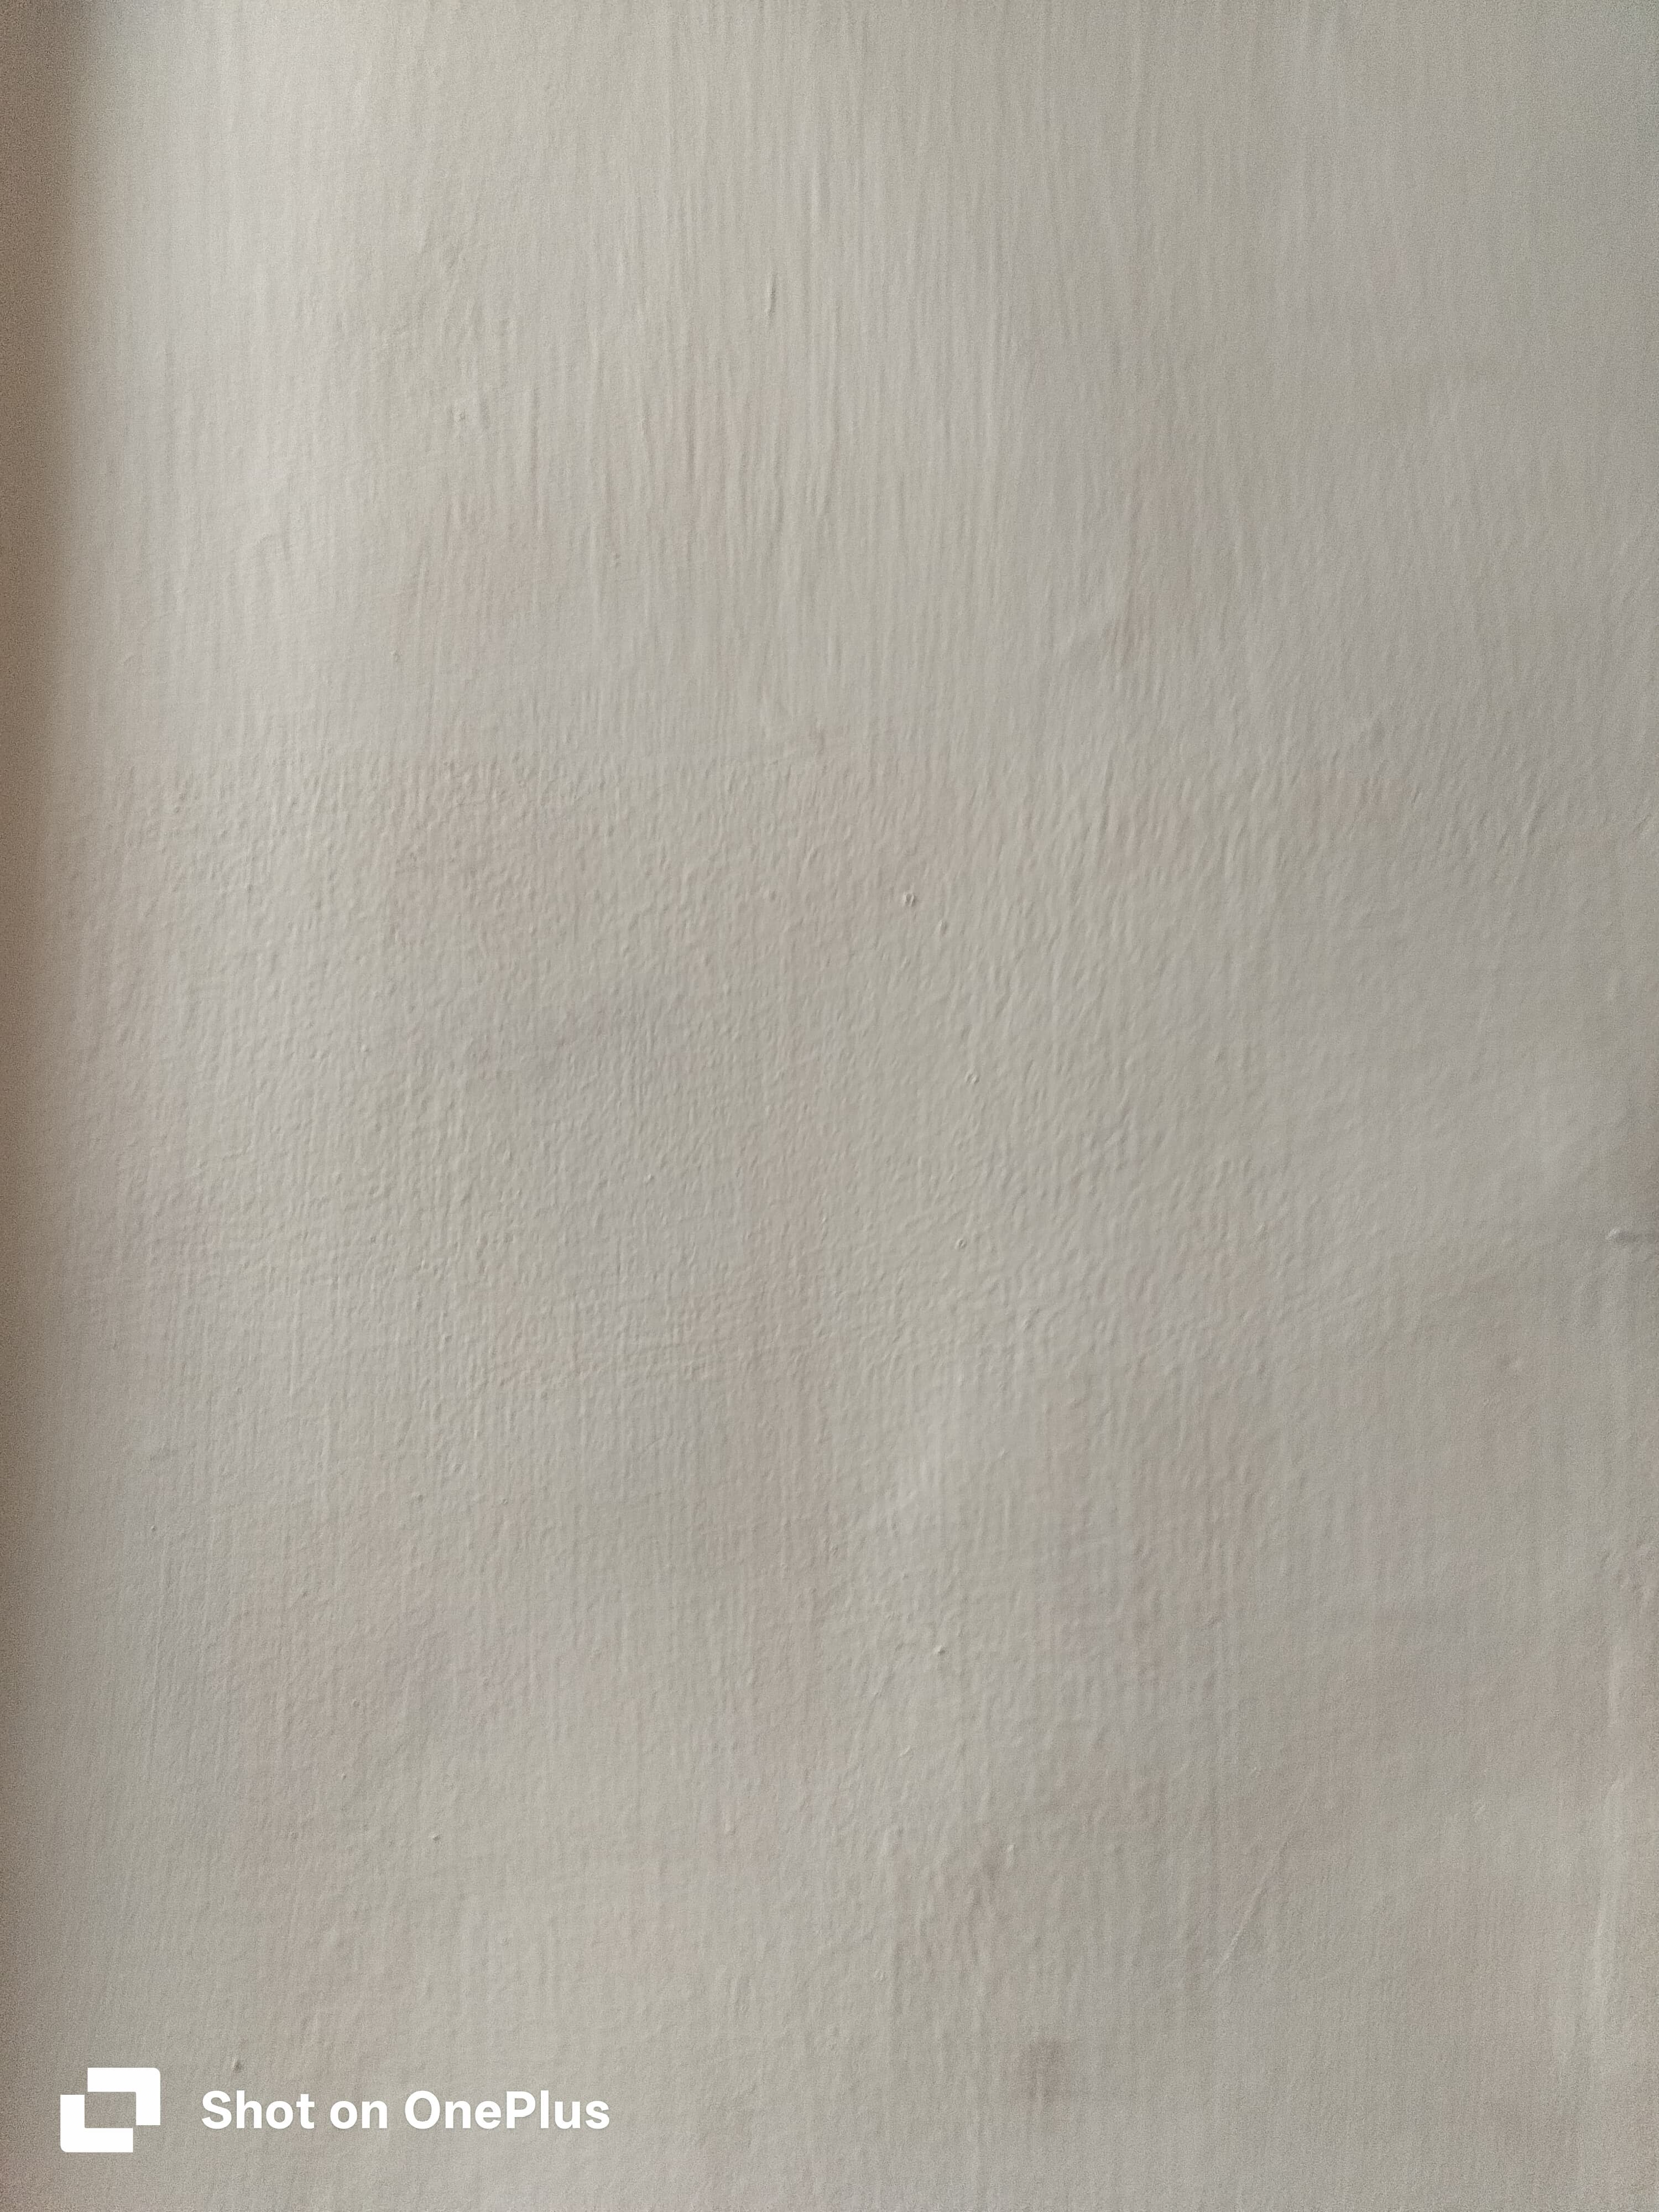

User uploaded file "WhatsApp Image 2025-05-05 at 4.23.12 PM (2).jpeg" with length 461140 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
No crack detected.


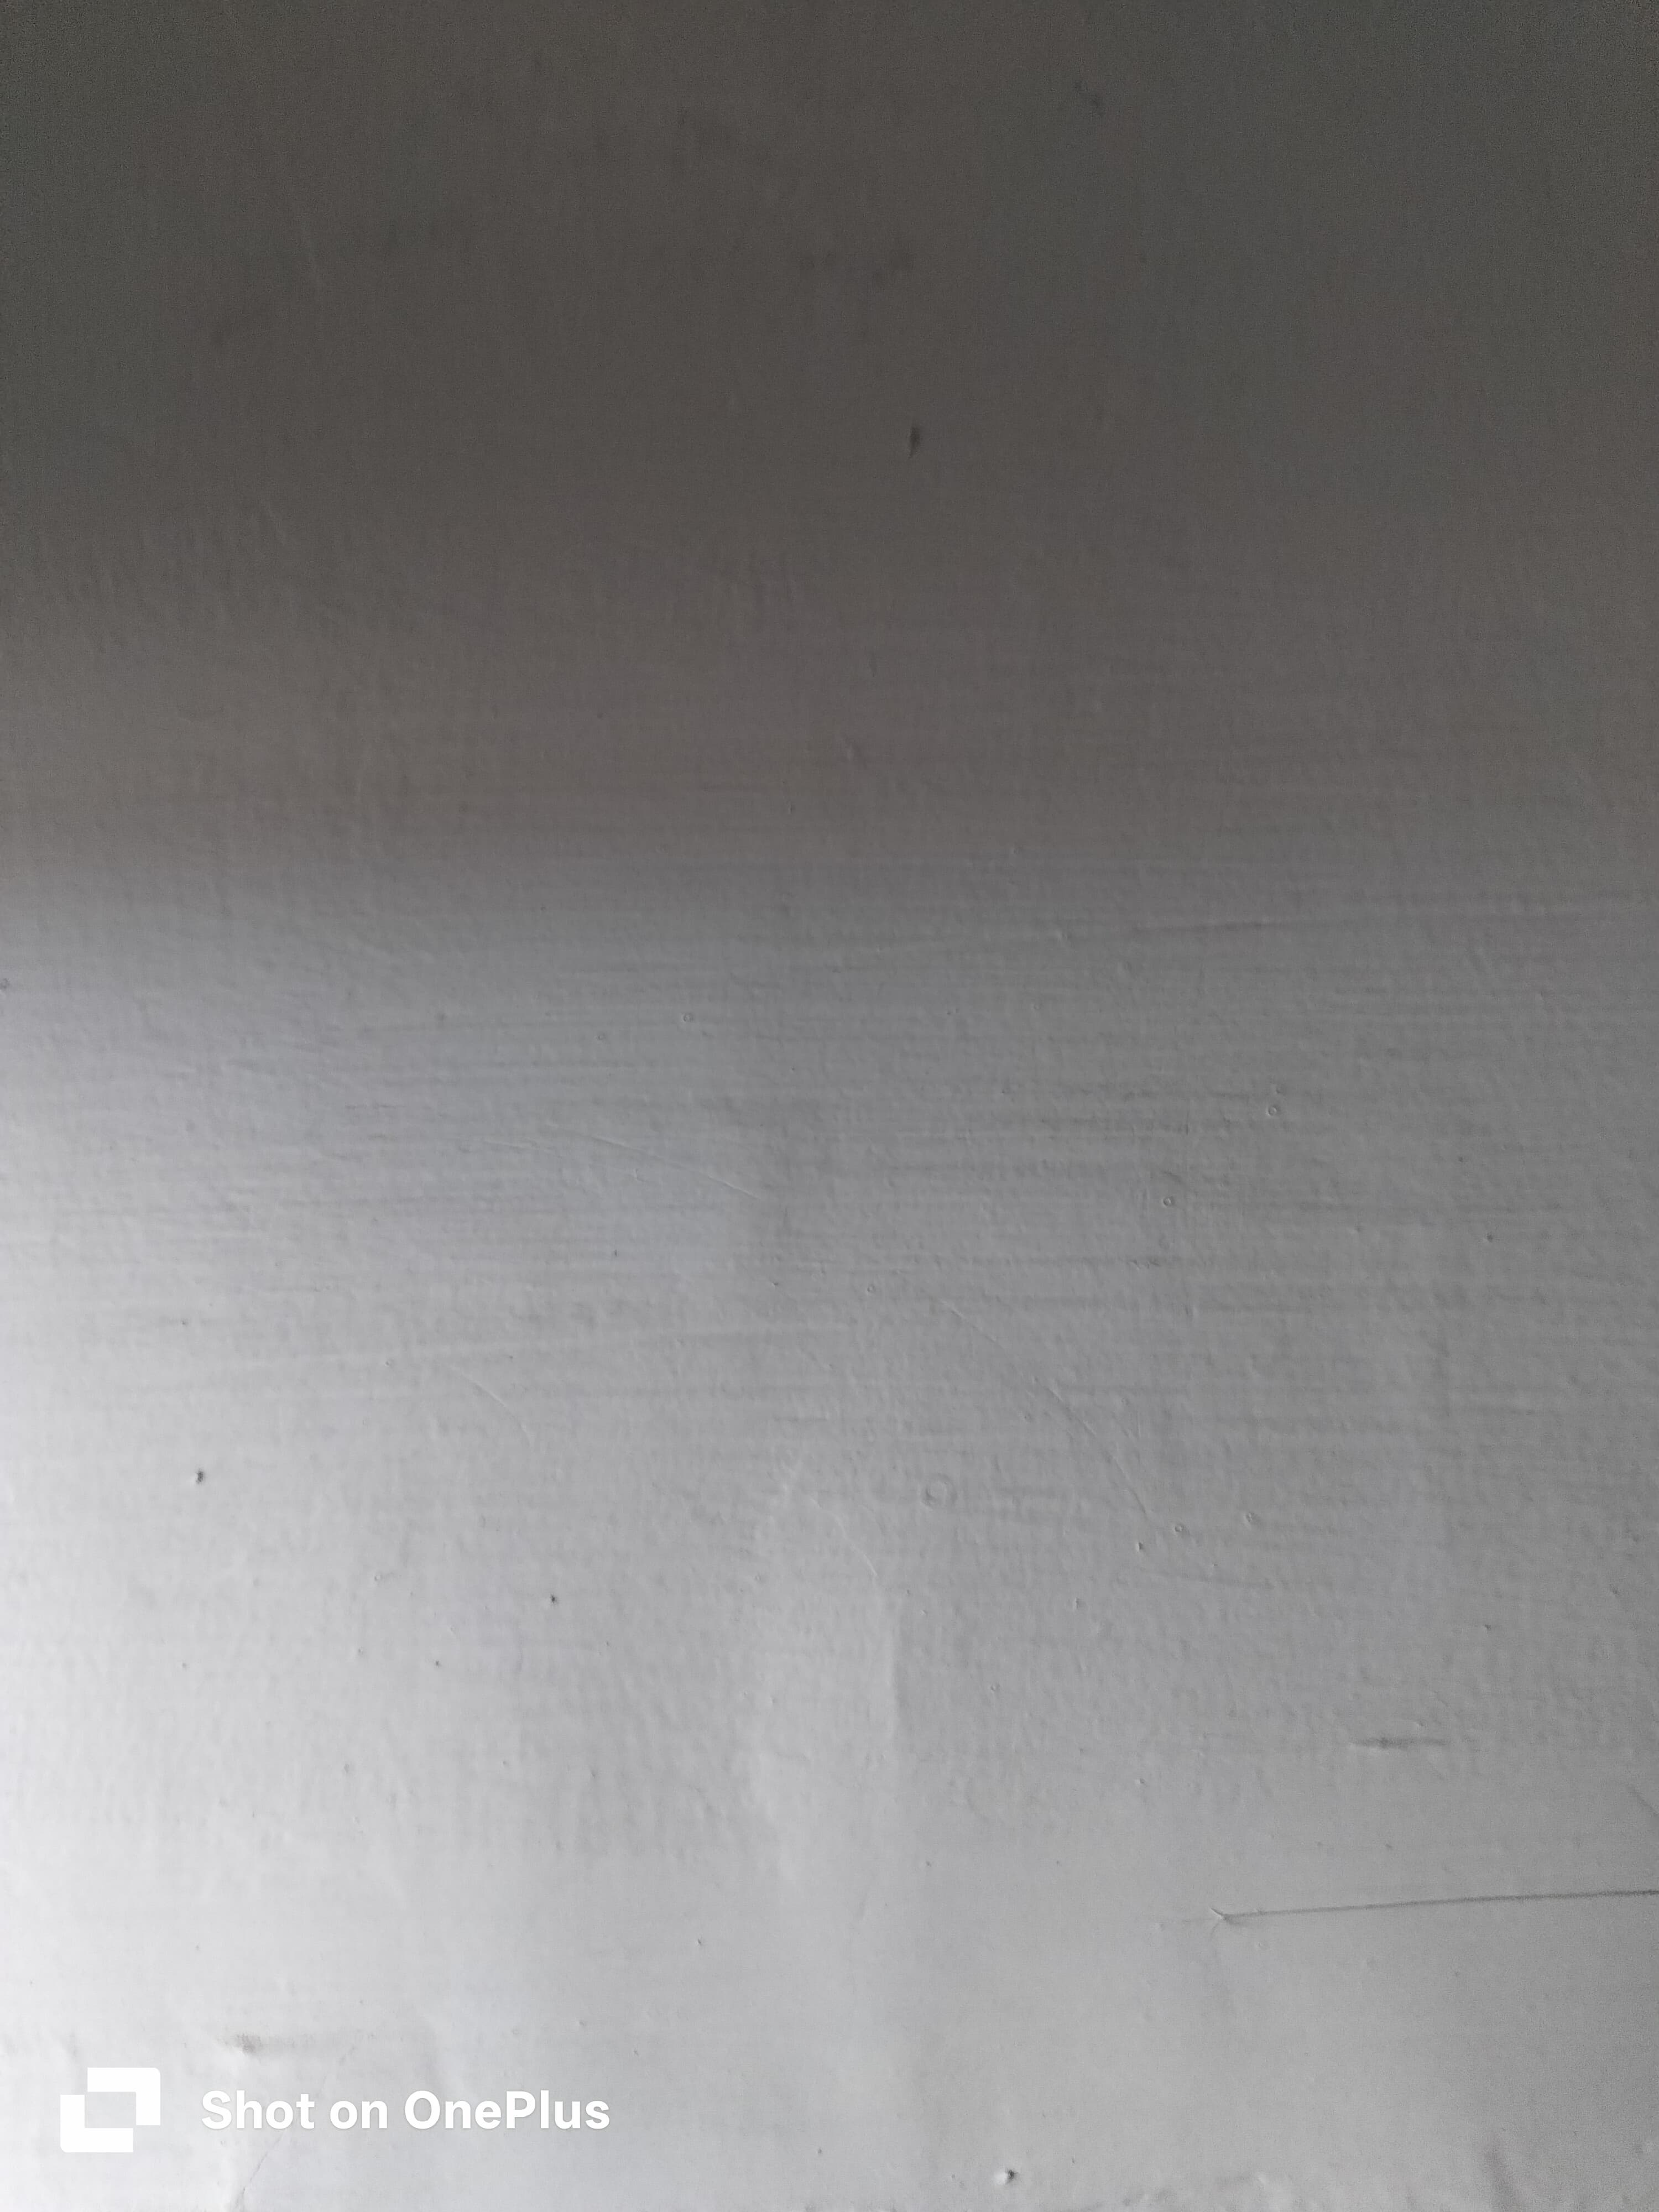

User uploaded file "WhatsApp Image 2025-05-05 at 4.23.12 PM (1).jpeg" with length 283986 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
No crack detected.


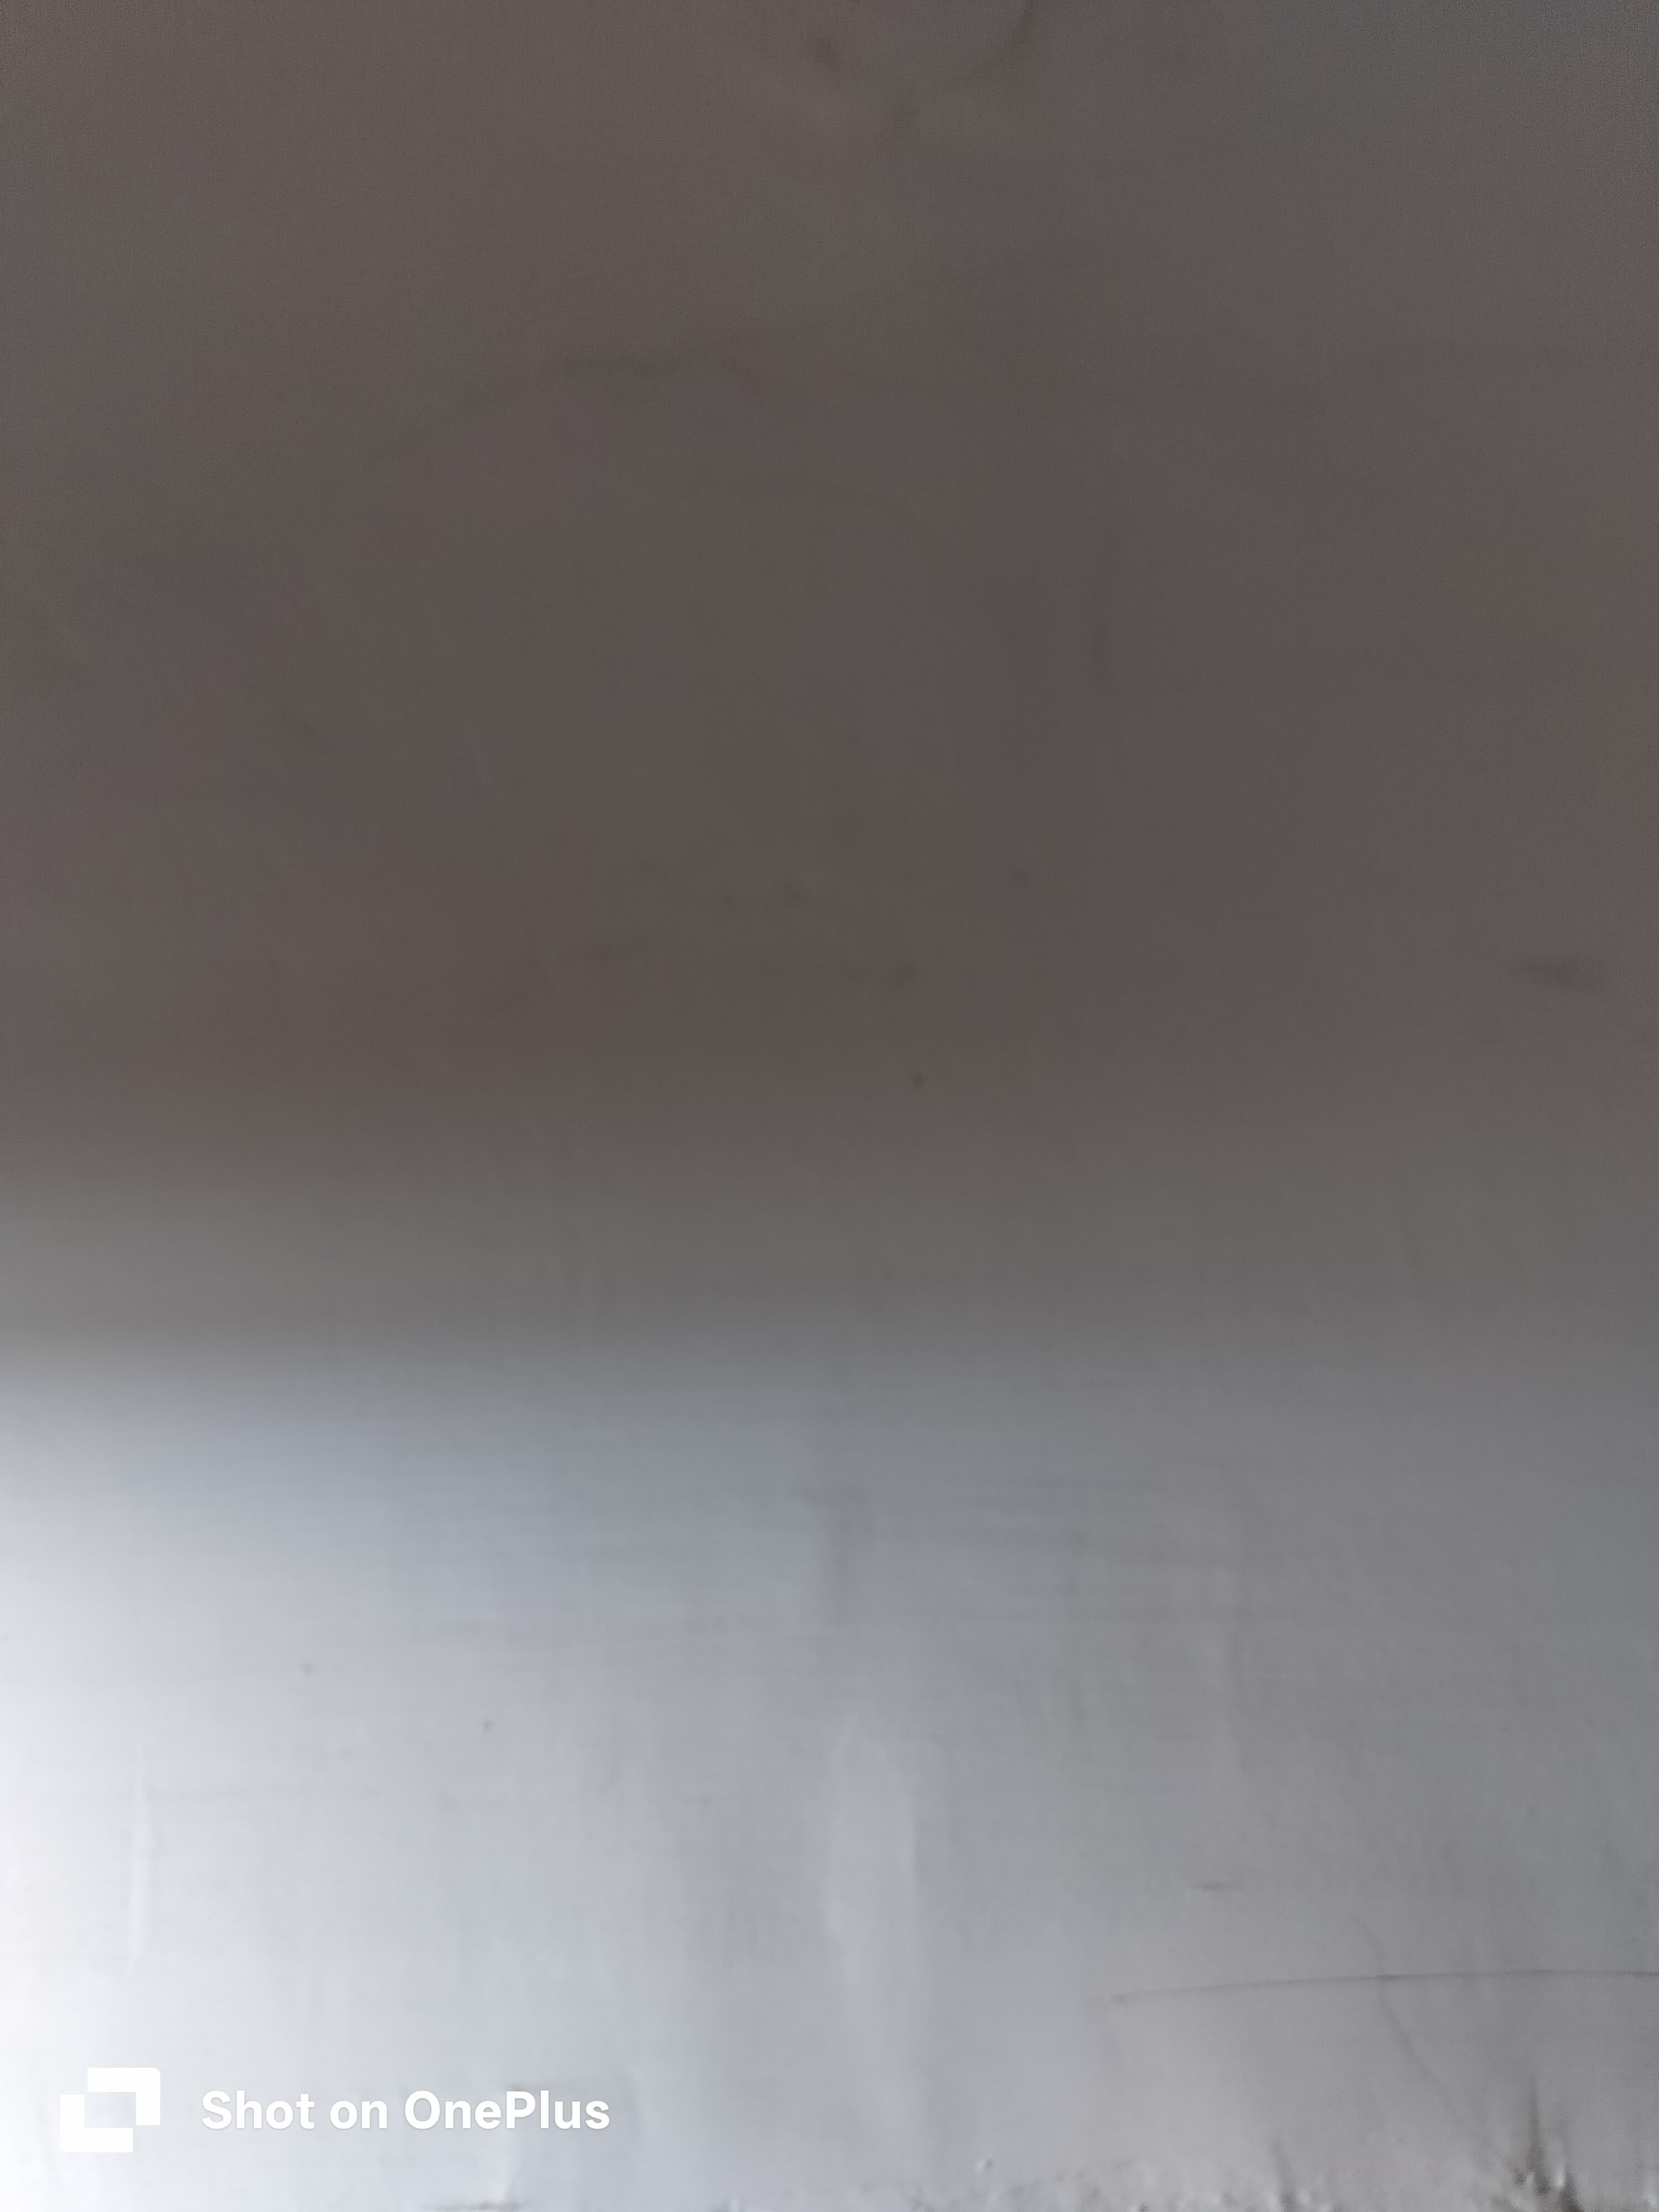

User uploaded file "WhatsApp Image 2025-05-05 at 4.23.12 PM.jpeg" with length 178489 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
No crack detected.


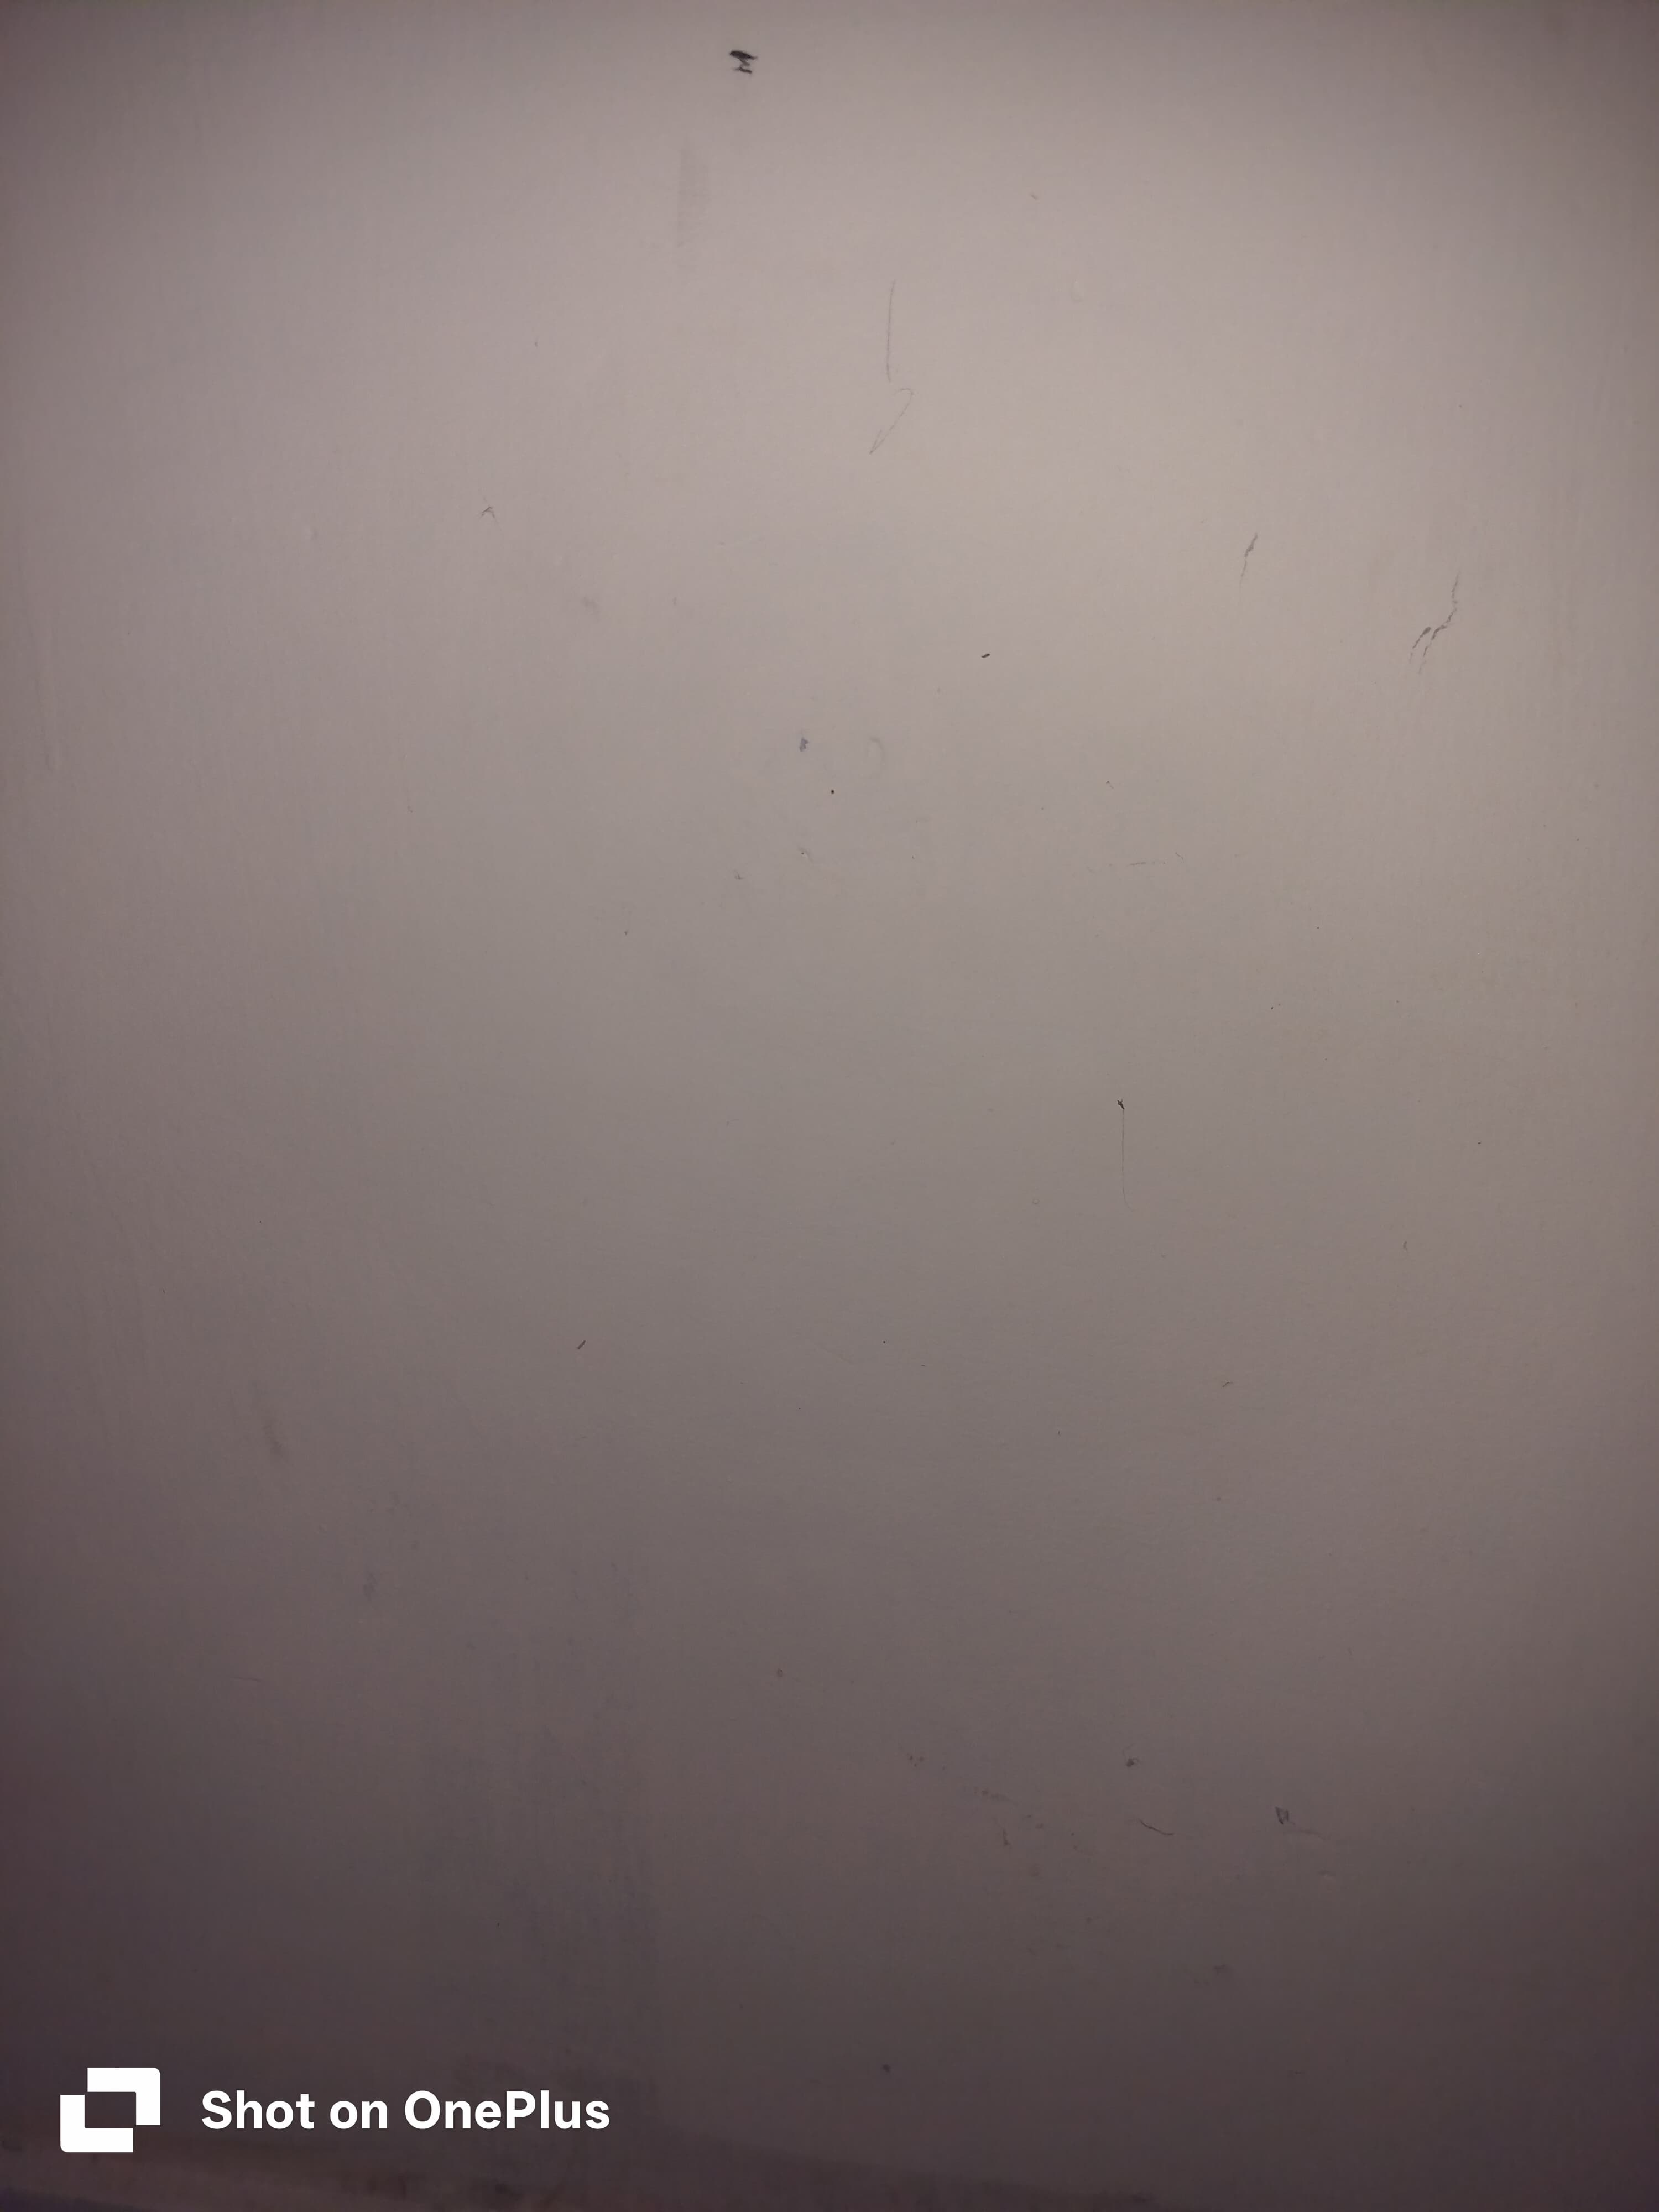

User uploaded file "WhatsApp Image 2025-05-06 at 1.08.20 AM.jpeg" with length 716438 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
No crack detected.


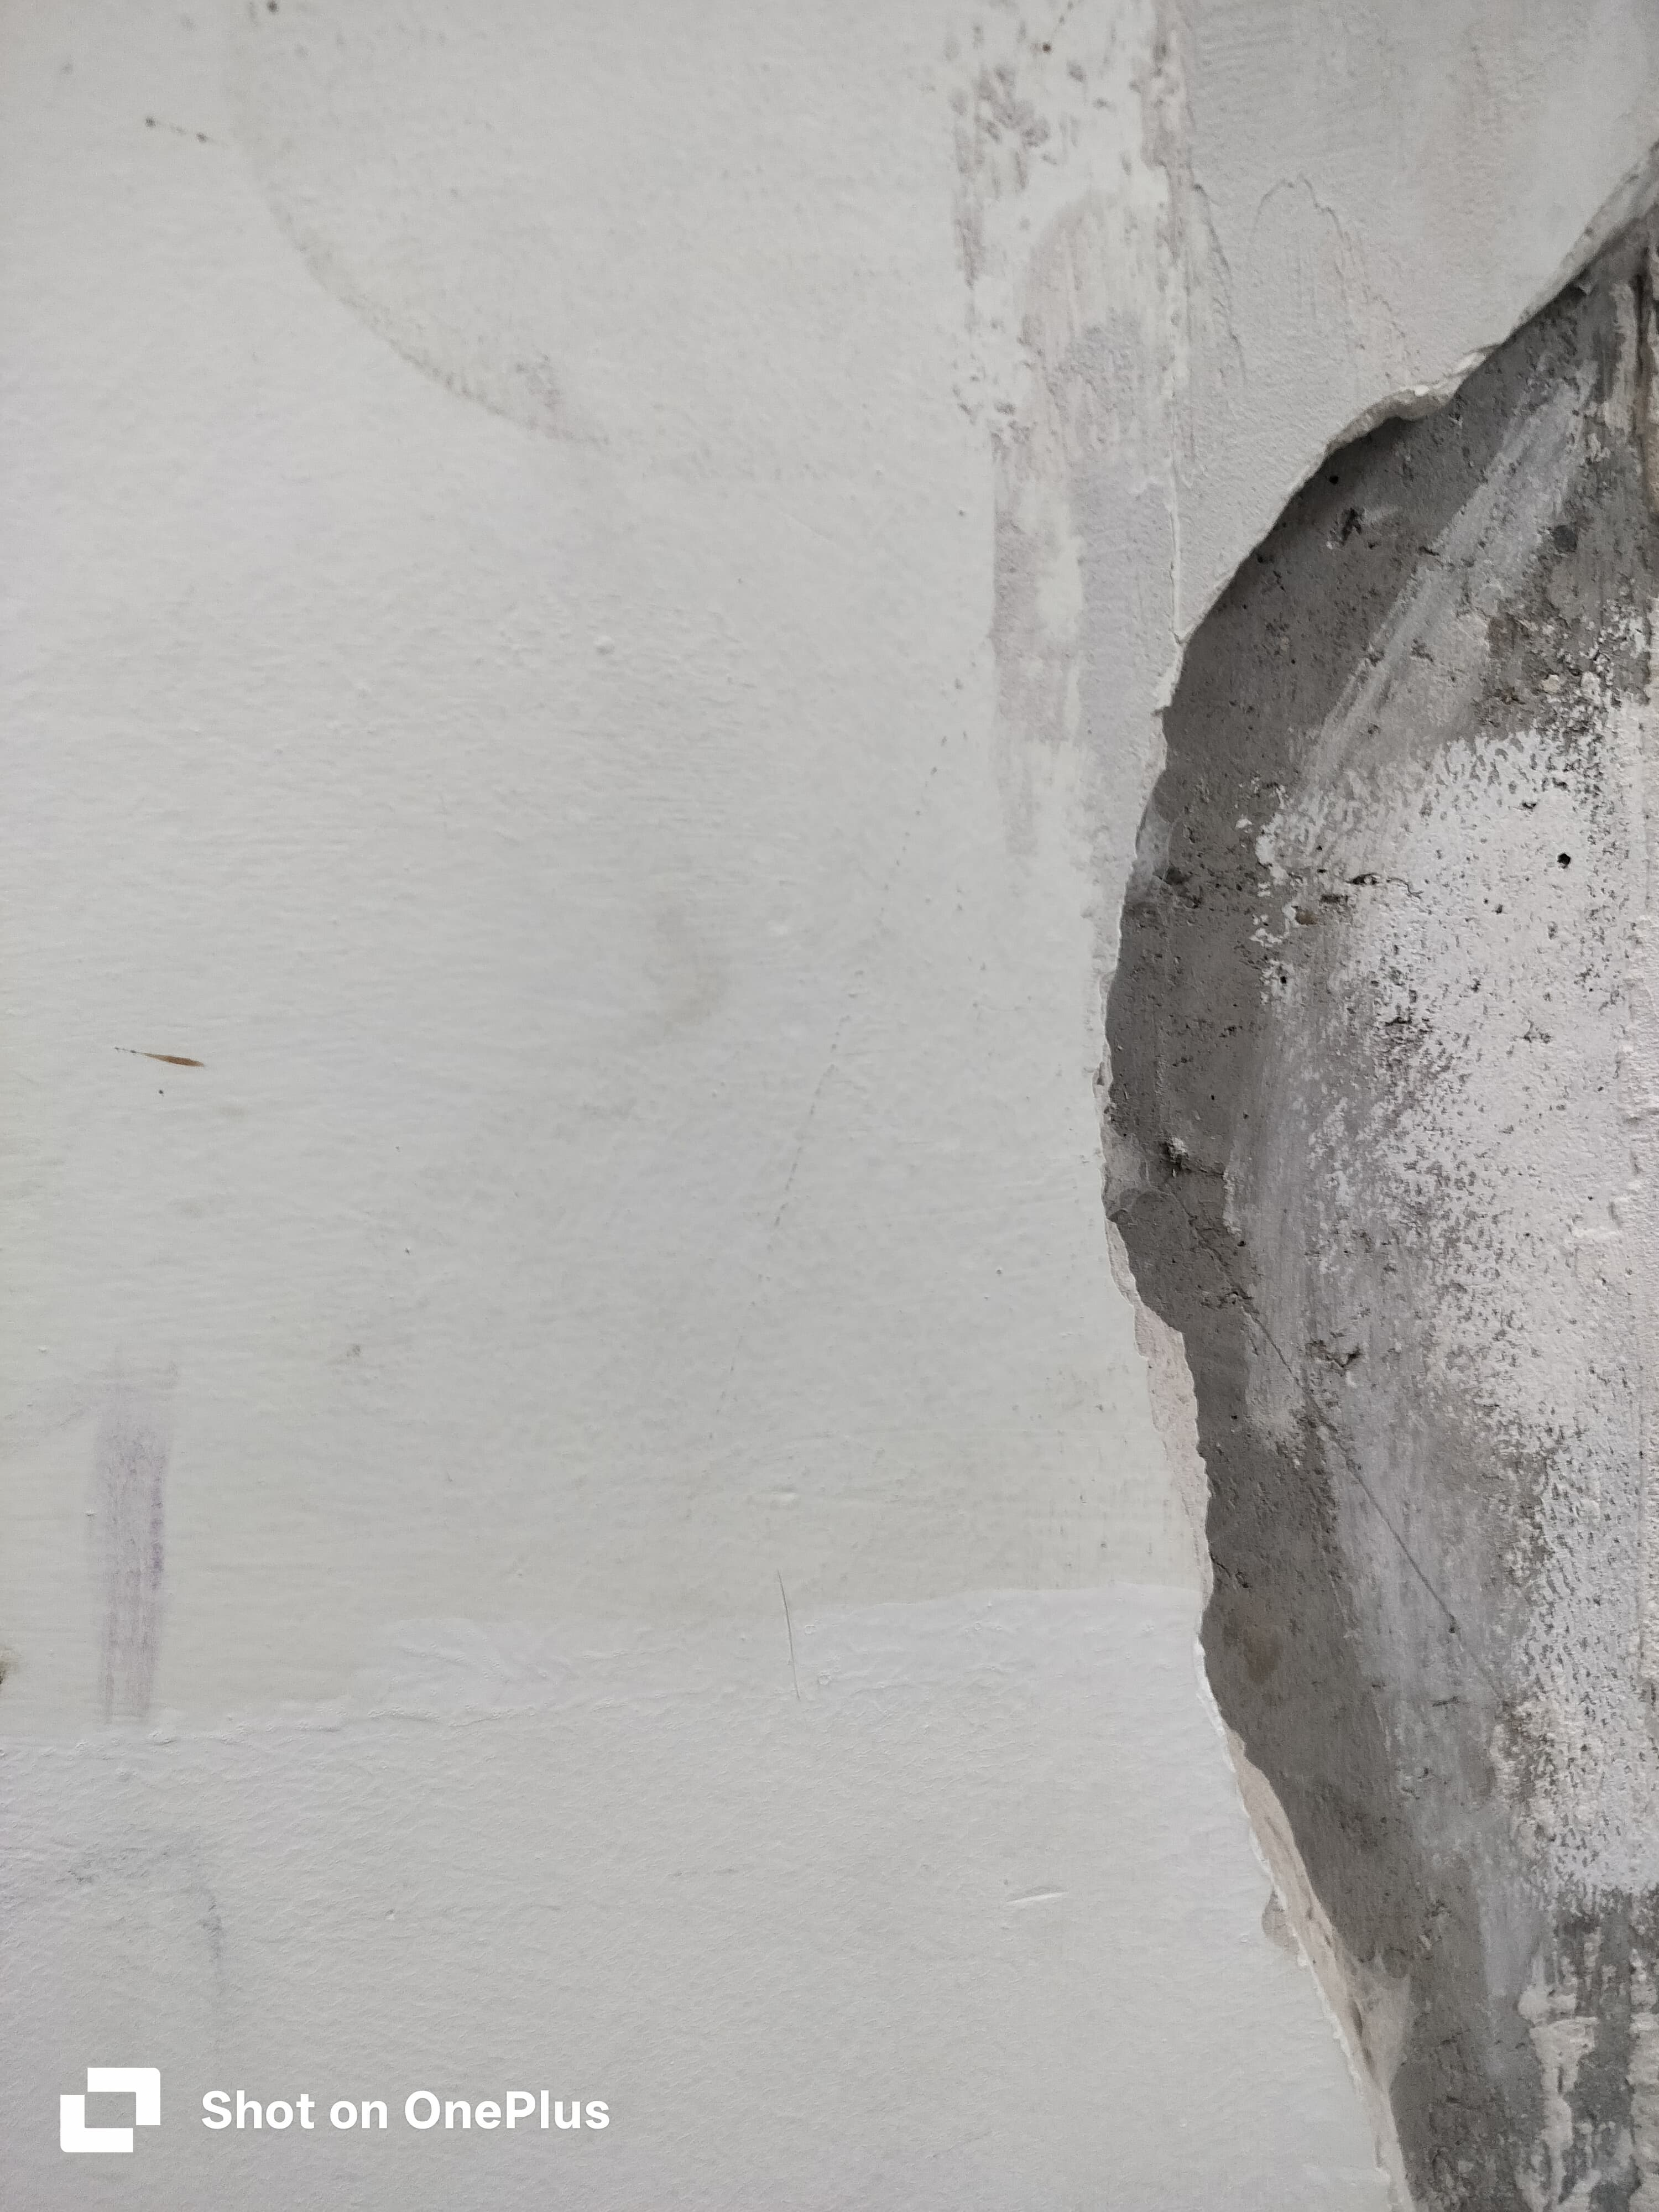

User uploaded file "WhatsApp Image 2025-05-06 at 1.08.19 AM.jpeg" with length 309044 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
No crack detected.


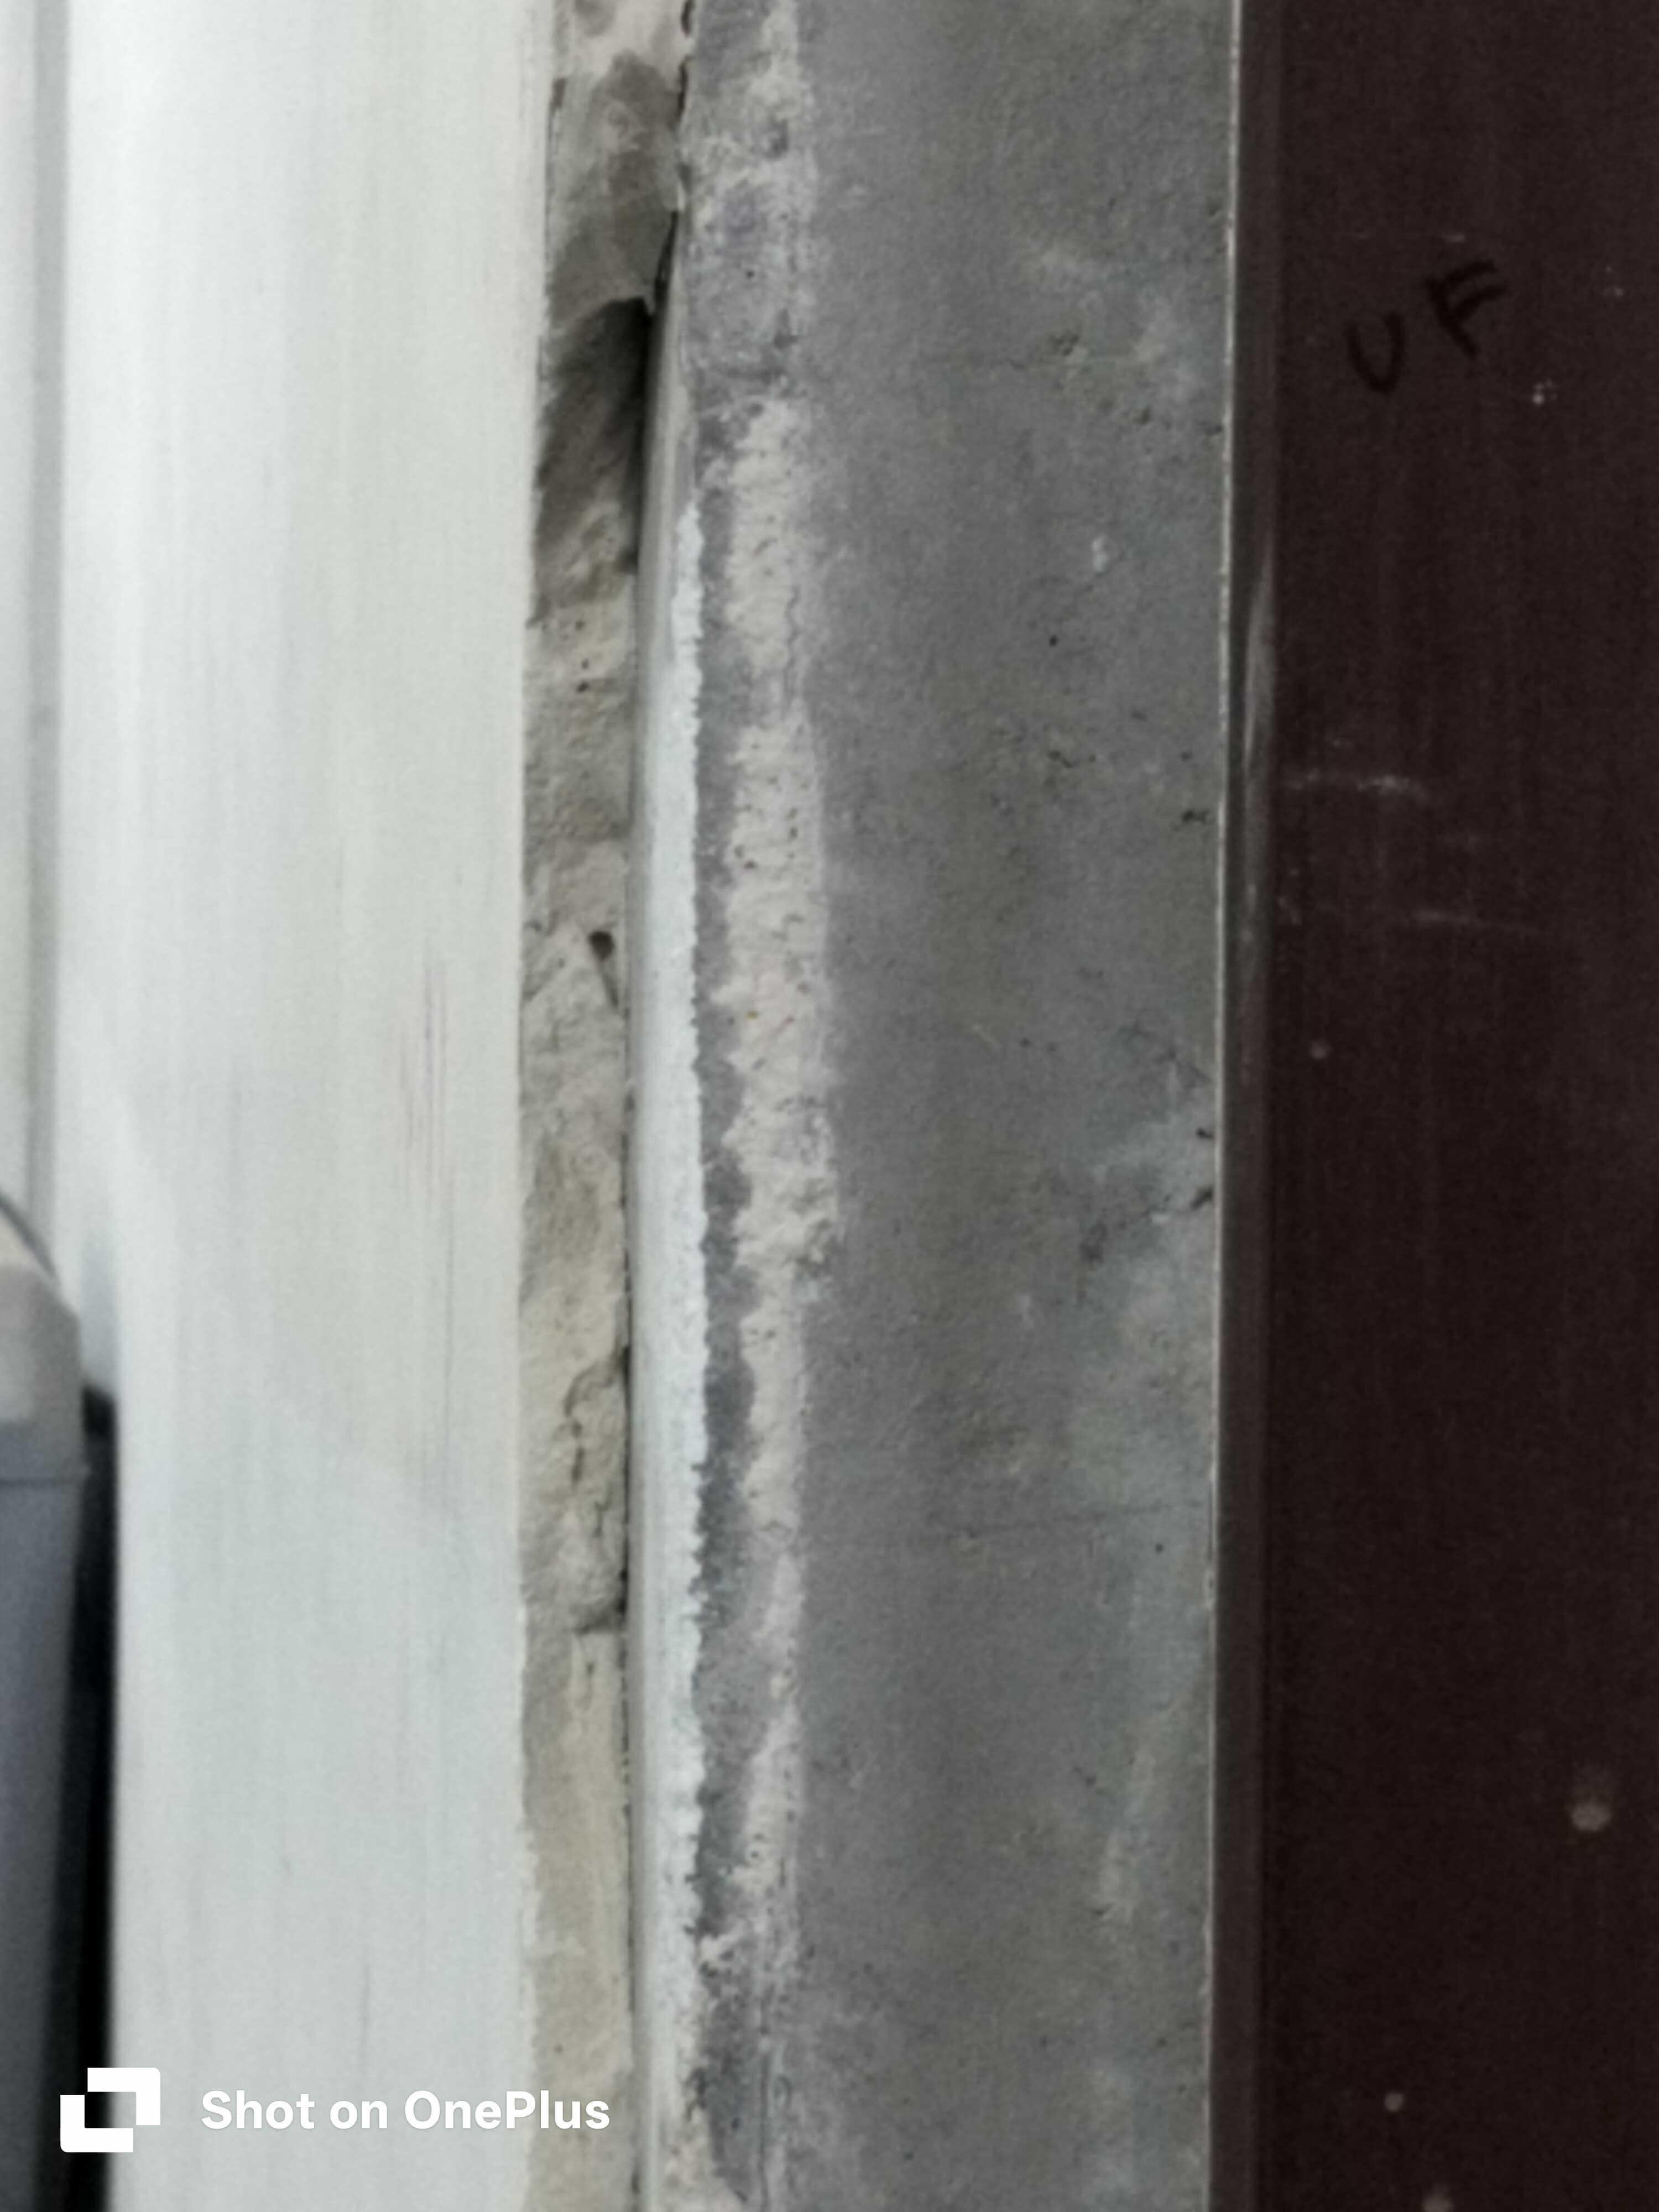

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import display, Image
from google.colab import files

def predict_crack(image_path, model):
  img = image.load_img(image_path, target_size=(120, 120))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  prediction = model.predict(img_array)[0][0]

  if prediction > 0.5:
    print("Crack detected!")
    display(Image(filename=image_path))
  else:
    print("No crack detected.")
    display(Image(filename=image_path))
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  predict_crack(fn, model)

<Axes: >

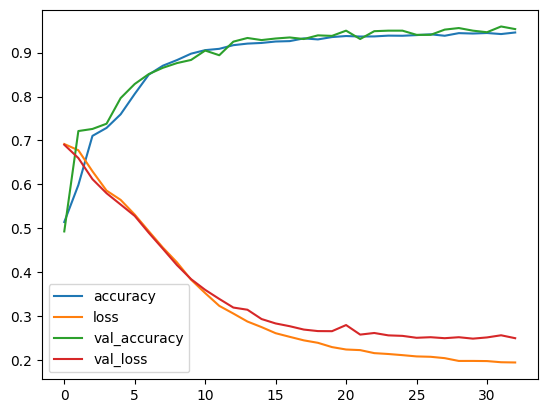

In [ ]:
import os
Grap_Data = pd.DataFrame(history.history)
Grap_Data.plot()

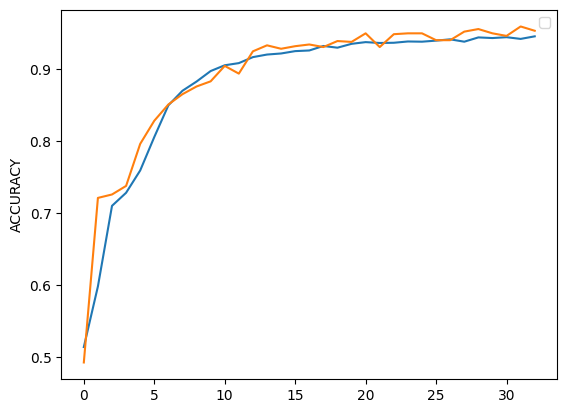

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

In [ ]:
figure = px.line(
    history.history,
    y=["loss", "val_loss"],
    labels={"index": "Epoch", "value": "Loss"},
    title = "Training and Validation Loss Over Time"
)

figure.show()